# Assignment Two:  Sentiment Classification

For this exercise you will be using the "SemEval 2017 task 4" corpus provided on the module website, available through the following link: https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs918/semeval-tweets.tar.bz2 You will focus particularly on Subtask A, i.e. classifying the overall sentiment of a tweet as positive, negative or neutral.

You are requested to produce a Jupyter notebook for the coursework submission. The input to your program is the SemEval data downloaded. Note that TAs need to run your program on their own machine by using the original SemEval data. As such, don’t submit a Python program that takes as input some preprocessed files.

#### Import necessary packages
You may import more packages here.

In [ ]:
# Import necessary packages
import re
import nltk
import torch
import string
import warnings
import numpy as np
import torch.nn as nn
from os.path import join
import torch.optim as optim
from sklearn.svm import SVC
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import pickle

In [ ]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']
trainset = ['twitter-training-data.txt']
devset = ['twitter-dev-data.txt']
glove_path = 'glove.6B.100d.txt'

In [ ]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)

In [ ]:
# Download necessary NLTK resources
nltk.download('wordnet')  # For lemmatization
nltk.download('averaged_perceptron_tagger')  # For POS tagging
nltk.download('punkt')  # For tokenization
nltk.download('stopwords') #For stopwords

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rifhathaslamj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rifhathaslamj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rifhathaslamj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rifhathaslamj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Load training set, dev set and testing set
Here, you need to load the training set, the development set and the test set. For better classification results, you may need to preprocess tweets before sending them to the classifiers.

In [ ]:
# Define datasets
train_datasets = trainset
dev_datasets = devset
test_datasets = testsets  # List of test datasets

# Load datasets
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

dev_data = {}
dev_tweetids = {}
dev_tweetgts = {}
dev_tweets = {}

test_data = {}  # Initialize dictionary for test datasets
test_tweetids = {}
test_tweetgts = {}
test_tweets = {}

datasets = train_datasets + dev_datasets + test_datasets  # Concatenate all dataset lists

for dataset in datasets:
    data[dataset] = []
    tweets[dataset] = []
    tweetids[dataset] = []
    tweetgts[dataset] = []

    with open(join('semeval-tweets', dataset), 'r', encoding='utf-8') as file:
        for line in file:
            tweet_id, sentiment, tweet_text = line.strip().split('\t')
            data[dataset].append((tweet_id, sentiment, tweet_text))
            tweetids[dataset].append(tweet_id)
            tweetgts[dataset].append(sentiment)
            tweets[dataset].append(tweet_text)

    if dataset in dev_datasets:
        dev_data[dataset] = data[dataset]
        dev_tweets[dataset] = tweets[dataset]
        dev_tweetids[dataset] = tweetids[dataset]
        dev_tweetgts[dataset] = tweetgts[dataset]
    elif dataset in test_datasets:
        test_data[dataset] = data[dataset]
        test_tweets[dataset] = tweets[dataset]
        test_tweetids[dataset] = tweetids[dataset]
        test_tweetgts[dataset] = tweetgts[dataset]

# Printing the values
# Printing the first 5 entries
print("Training Data:")
for dataset in train_datasets:
    print(f"Dataset: {dataset}")
    print("Data:")
    for i in range(min(5, len(data[dataset]))):
        tweet_id, sentiment, tweet_text = data[dataset][i]
        print(f"Tweet ID: {tweet_id}, Sentiment: {sentiment}, Tweet Text: {tweet_text}")

print("\nDevelopment Data:")
for dataset in dev_datasets:
    print(f"Dataset: {dataset}")
    print("Data:")
    for i in range(min(5, len(dev_data[dataset]))):
        tweet_id, sentiment, tweet_text = dev_data[dataset][i]
        print(f"Tweet ID: {tweet_id}, Sentiment: {sentiment}, Tweet Text: {tweet_text}")

print("\nTest Data:")
for dataset in test_datasets:
    print(f"Dataset: {dataset}")
    print("Data:")
    for i in range(min(5, len(test_data[dataset]))):
        tweet_id, sentiment, tweet_text = test_data[dataset][i]
        print(f"Tweet ID: {tweet_id}, Sentiment: {sentiment}, Tweet Text: {tweet_text}")

Training Data:
Dataset: twitter-training-data.txt
Data:
Tweet ID: 335104872099066692, Sentiment: positive, Tweet Text: Felt privileged to play Foo Fighters songs on guitar today with one of the plectrums from the gig on Saturday.
Tweet ID: 796528524030124618, Sentiment: positive, Tweet Text: "@AaqibAfzaal Pakistan may be an Islamic country, but der are a lot true Muslims in India who love their country and can sacrifice all for it"
Tweet ID: 760964834217238632, Sentiment: positive, Tweet Text: Happy Birthday to the coolest golfer in Bali! @tjvictoriacnd !! :) may you become cooler and cooler everyday! Stay humble little sister! Xx
Tweet ID: 147713180324524046, Sentiment: negative, Tweet Text: @SimpplyA TMILLS is going to Tucson! But the 29th and it's on a Thursday :(
Tweet ID: 732302280474120023, Sentiment: negative, Tweet Text: Hmmmmm where are the #BlackLivesMatter when matters like this a rise... kids are a disgrace!! https://t.co/aPrB0VtvCN

Development Data:
Dataset: twitter-dev-d

Preprocessing

In [ ]:
import re
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize tokenizer
tokenizer = TweetTokenizer()

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define function for tweet preprocessing
def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()

    # Remove mentions
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove emojis
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')

    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Tokenize tweet
    tokens = tokenizer.tokenize(tweet)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove hashtags
    tokens = [token for token in tokens if not token.startswith('#')]

    # Lemmatize tokens
    lemmatizer_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a string
    preprocessed_tweet = ' '.join(lemmatizer_tokens)

    return preprocessed_tweet

# Preprocess tweets in the dataset and return preprocessed text
def preprocess_dataset_return_text(dataset):
    preprocessed_texts = []
    for _, _, tweet_text in dataset:
        preprocessed_text = preprocess_tweet(tweet_text)
        preprocessed_texts.append(preprocessed_text)
    return preprocessed_texts

preprocessed_training_texts = {}
for train_dataset in train_datasets:
    preprocessed_training_texts[train_dataset] = preprocess_dataset_return_text(data[train_dataset])

# Preprocess development datasets and get preprocessed text
preprocessed_dev_texts = {}
for dev_dataset in dev_datasets:
    preprocessed_dev_texts[dev_dataset] = preprocess_dataset_return_text(dev_data[dev_dataset])

preprocessed_test_texts = {}
for test_dataset in test_datasets:
    preprocessed_test_texts[test_dataset] = preprocess_dataset_return_text(test_data[test_dataset])


# Print preprocessed text
print("Preprocessed Training Texts:")
for dataset, texts in preprocessed_training_texts.items():
    print(f"Dataset: {dataset}")
    for preprocessed_text in texts[:5]:  # Print first 5 preprocessed texts
        print(f"Preprocessed Text: {preprocessed_text}")

print("\nPreprocessed Development Texts:")
for dataset, texts in preprocessed_dev_texts.items():
    print(f"Dataset: {dataset}")
    for preprocessed_text in texts[:5]:  # Print first 5 preprocessed texts
        print(f"Preprocessed Text: {preprocessed_text}")

print("\nPreprocessed Test Texts:")
for dataset, texts in preprocessed_test_texts.items():
    print(f"Dataset: {dataset}")
    for preprocessed_text in texts[:5]:  # Print first 5 preprocessed texts
        print(f"Preprocessed Text: {preprocessed_text}")


Preprocessed Training Texts:
Dataset: twitter-training-data.txt
Preprocessed Text: felt privileged play foo fighter song guitar today one plectrum gig saturday
Preprocessed Text: pakistan may islamic country der lot true muslim india love country sacrifice
Preprocessed Text: happy birthday coolest golfer bali may become cooler cooler everyday stay humble little sister xx
Preprocessed Text: tmills going tucson 29th thursday
Preprocessed Text: hmmmmm blacklivesmatter matter like rise kid disgrace

Preprocessed Development Texts:
Dataset: twitter-dev-data.txt
Preprocessed Text: hey im gonna dublin february know im saying
Preprocessed Text: literally excited im going sam smith concert october
Preprocessed Text: option buy 2gb ram model moto g 3rd gen instead 1gb model
Preprocessed Text: little m philippine littlemsphilippines unitednations
Preprocessed Text: know tpp expanded war drone strike mass surveillance

Preprocessed Test Texts:
Dataset: twitter-test1.txt
Preprocessed Text: candids 

Feature Extraction

In [ ]:
# GloVe embeddings loader
def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

# Tweets to GloVe embedding converter
def tweet_to_embedding(tweet, embeddings_dict, embedding_dim=100):
    words = tweet.split()
    accumulated_vector = np.zeros(embedding_dim)
    word_count = 0
    for word in words:
        if word in embeddings_dict:
            accumulated_vector += embeddings_dict[word]
            word_count += 1
    return accumulated_vector / word_count if word_count > 0 else accumulated_vector

# Specify the paths

# glove_path = 'glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)



glove_train = np.array([tweet_to_embedding(tweet, glove_embeddings) for tweet in preprocessed_training_texts['twitter-training-data.txt']])

# Initialize CountVectorizer with custom preprocessor
vectorizer = CountVectorizer(preprocessor = lambda x: x, tokenizer=word_tokenize)

# Fit and transform the data (only tokenization will be performed)
vectorizer.fit(preprocessed_training_texts['twitter-training-data.txt'])
train_bow = vectorizer.transform(preprocessed_training_texts['twitter-training-data.txt'])

def preprocess_and_extract_features(dataset_path, vectorizer, glove_embeddings):
    # Initialize lists to hold tweets and their IDs
    tweets = []
    tweet_ids = []  # List to store tweet IDs

    with open(dataset_path, 'r', encoding='utf8') as file:
        for line in file:
            tweet_id, sentiment, tweet_text = line.strip().split('\t')
            preprocessed_text = preprocess_tweet(tweet_text)  # Ensure preprocess_tweet is defined
            tweets.append(preprocessed_text)
            tweet_ids.append(tweet_id)  # Append the tweet ID

    # Extract BoW features
    X_bow = vectorizer.transform(tweets).toarray()  # Convert to dense array if needed

    # Extract GloVe features
    X_glove = np.array([tweet_to_embedding(tweet, glove_embeddings) for tweet in tweets])  # Ensure tweet_to_embedding is defined

    return tweet_ids, X_bow, X_glove

#### Build sentiment classifiers
You need to create your own classifiers (at least 3 classifiers). For each classifier, you can choose between the bag-of-word features and the word-embedding-based features. Each classifier has to be evaluated over 3 test sets. Make sure your classifier produce consistent performance across the test sets. Marking will be based on the performance over all 5 test sets (2 of them are not provided to you).

In [ ]:

import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        # No embedding layer needed, directly use GloVe embeddings
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
      lstm_out, _ = self.lstm(x)

      # Since lstm_out is [batch_size, hidden_size], we can directly pass it to the fully connected layer
      output = self.fc(lstm_out)
      return output


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
y_train = [sentiment for dataset in train_datasets for sentiment in tweetgts[dataset]]

In [ ]:
import pickle
import os

for classifier in ['svm', 'logistic_regression', 'LSTM']:
    for features in ['bow', 'glove']:
        if classifier == 'svm' or classifier == 'logistic_regression':
            # Check if pickle exists
            model_filename = f'{classifier}_{features}_model.pkl'
            if os.path.exists(model_filename):
                # Load the model from the pickle file
                with open(model_filename, 'rb') as f:
                    model = pickle.load(f)
                print(f"Model '{model_filename}' loaded from pickle file.")
            else:
                # Train the model
                if classifier == 'svm':
                    model = SVC(kernel='linear', C=1.0)
                elif classifier == 'logistic_regression':
                    model = LogisticRegression(max_iter=1000)
                # Train the model using features X_train and y_train
                model.fit(X_train, y_train)
                # Save the trained model to a pickle file
                with open(model_filename, 'wb') as f:
                    pickle.dump(model, f)
                print(f"Model '{model_filename}' trained and saved to pickle file.")
        elif classifier == 'LSTM':
            if features == 'bow':
                continue
            label_encoder = LabelEncoder()
            y_train_encoded = label_encoder.fit_transform(np.array(tweetgts['twitter-training-data.txt']))
            model_filename = f'{classifier}_{features}_model.pkl'
            if os.path.exists(model_filename):
                # Load the model from the pickle file
                with open(model_filename, 'rb') as f:
                    model = pickle.load(f)
                print(f"Model '{model_filename}' loaded from pickle file.")
            else:
                print('Training ' + classifier)
                # Directly use LabelEncoder on your labels
                label_encoder = LabelEncoder()
                y_train_encoded = label_encoder.fit_transform(np.array(tweetgts['twitter-training-data.txt']))

                # Convert labels to tensor
                y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

                # Convert GloVe features to tensor
                X_train_glove_tensor = torch.tensor(X_train, dtype=torch.float32)

                # Create dataset and dataloader for GloVe
                train_glove_dataset = TensorDataset(X_train_glove_tensor, y_train_tensor)
                train_glove_loader = DataLoader(train_glove_dataset, batch_size=64, shuffle=True, drop_last=True)

                # Define LSTM model
                input_dim = 100  # Assuming you're using GloVe vectors of 100 dimensions
                hidden_dim = 256
                num_classes = len(label_encoder.classes_)
                output_dim = len(label_encoder.classes_)
                model = LSTM(input_dim, hidden_dim, num_classes).to(device)

                # Directly use LabelEncoder on your labels
                label_encoder = LabelEncoder()
                y_train_encoded = label_encoder.fit_transform(np.array(tweetgts['twitter-training-data.txt']))

                # Convert labels to tensor
                y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)


                # Loss and optimizer
                loss_function = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters())

                # Train LSTM
                epochs = 5
                for epoch in range(epochs):
                    model.train()
                    for inputs, labels in train_glove_loader:
                        optimizer.zero_grad()
                        # Ensure inputs and labels are on the correct device (if using GPU)
                        inputs, labels = inputs.to(device), labels.to(device)

                        outputs = model(inputs)

                        # Dynamically calculate loss based on the actual size of the batch
                        loss = loss_function(outputs, labels)
                        loss.backward()
                        optimizer.step()
                    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

                # Save the trained LSTM model
                with open(model_filename, 'wb') as f:
                    pickle.dump(model, f)
                print(f'Model saved as {model_filename}')

        else:
            print('Unknown classifier name' + classifier)
            continue

        # Your prediction and evaluation code here...
        for testset in testsets:
            tweet_ids, bow_test, glove_test = preprocess_and_extract_features(testset, vectorizer, glove_embeddings)

            # Choose the correct test features based on the feature type
            X_test = bow_test if features == 'bow' else glove_test

            if classifier == 'LSTM':
                X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
                model.eval()
                with torch.no_grad():
                    outputs = model(X_test_tensor)
                    _, predictions_numeric = torch.max(outputs, 1)
                    # Convert numeric predictions back to original labels
                    predictions_labels = label_encoder.inverse_transform(predictions_numeric.cpu().numpy())
                # Map tweet IDs to their predicted labels for evaluation
                id_preds = {tweet_id: pred_label for tweet_id, pred_label in zip(tweet_ids, predictions_labels)}
            else:
               predictions = model.predict(X_test)
               id_preds = {tweet_id: pred for tweet_id, pred in zip(tweet_ids, predictions)}

            testset_name = testset
            testset_path = join('semeval-tweets', testset_name)
            evaluate(id_preds, testset_path, features + '-' + classifier)


Model 'svm_bow_model.pkl' loaded from pickle file.
semeval-tweets/twitter-test1.txt (bow-svm): 0.547
semeval-tweets/twitter-test2.txt (bow-svm): 0.563
semeval-tweets/twitter-test3.txt (bow-svm): 0.527
Model 'svm_glove_model.pkl' loaded from pickle file.
semeval-tweets/twitter-test1.txt (glove-svm): 0.385
semeval-tweets/twitter-test2.txt (glove-svm): 0.428
semeval-tweets/twitter-test3.txt (glove-svm): 0.417
Model 'logistic_regression_bow_model.pkl' loaded from pickle file.
semeval-tweets/twitter-test1.txt (bow-logistic_regression): 0.546
semeval-tweets/twitter-test2.txt (bow-logistic_regression): 0.567
semeval-tweets/twitter-test3.txt (bow-logistic_regression): 0.530
Model 'logistic_regression_glove_model.pkl' loaded from pickle file.
semeval-tweets/twitter-test1.txt (glove-logistic_regression): 0.427
semeval-tweets/twitter-test2.txt (glove-logistic_regression): 0.452
semeval-tweets/twitter-test3.txt (glove-logistic_regression): 0.451
Model 'LSTM_glove_model.pkl' loaded from pickle file

Visual Representations


Training Data:


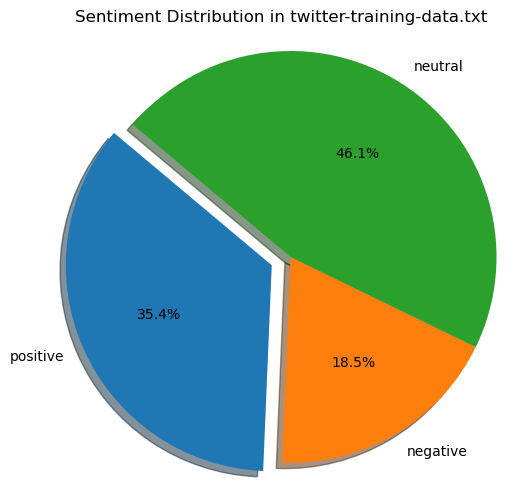


Development Data:


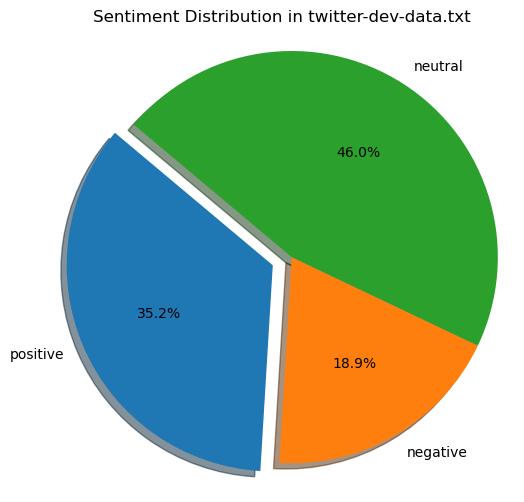


Test Data:


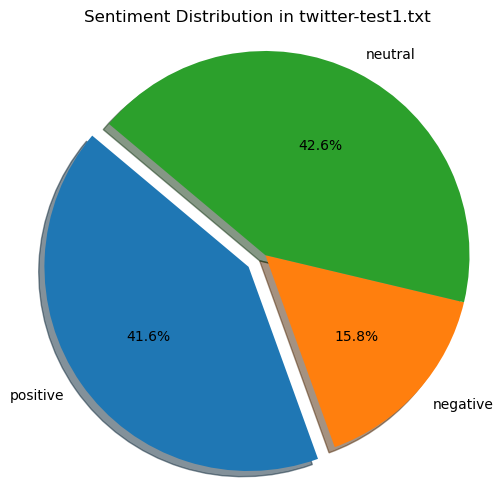

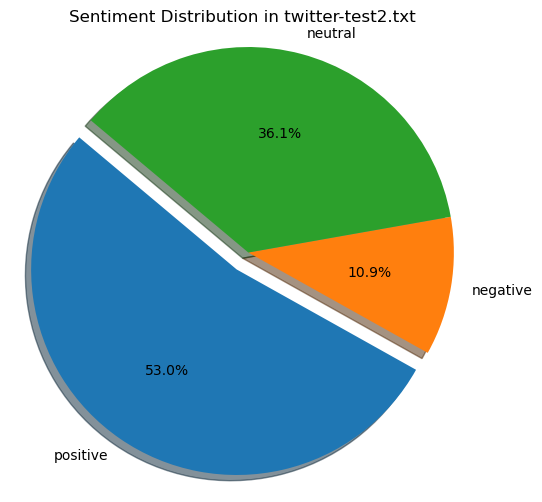

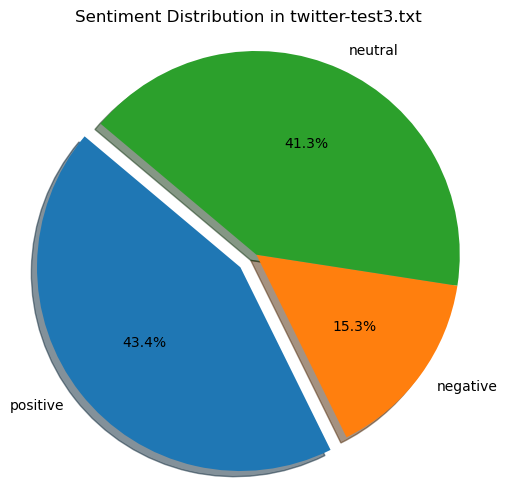

In [ ]:
import matplotlib.pyplot as plt

# Function to count sentiment occurrences
def count_sentiments(sentiments):
    counts = {'positive': 0, 'negative': 0, 'neutral': 0}
    for sentiment in sentiments:
        counts[sentiment] += 1
    return counts

# Function to plot sentiment distribution
def plot_sentiment_distribution(sentiment_counts, dataset_name):
    labels = sentiment_counts.keys()
    sizes = sentiment_counts.values()
    explode = (0.1, 0, 0)  # explode the 1st slice (positive)

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title(f"Sentiment Distribution in {dataset_name}")
    plt.show()

# Plot sentiment distribution for training data
print("Training Data:")
for dataset in train_datasets:
    sentiment_counts = count_sentiments(tweetgts[dataset])
    plot_sentiment_distribution(sentiment_counts, dataset)

# Plot sentiment distribution for development data
print("\nDevelopment Data:")
for dataset in dev_datasets:
    sentiment_counts = count_sentiments(dev_tweetgts[dataset])
    plot_sentiment_distribution(sentiment_counts, dataset)

# Plot sentiment distribution for test data
print("\nTest Data:")
for dataset in test_datasets:
    sentiment_counts = count_sentiments(test_tweetgts[dataset])
    plot_sentiment_distribution(sentiment_counts, dataset)


Preprocessed Training Texts:


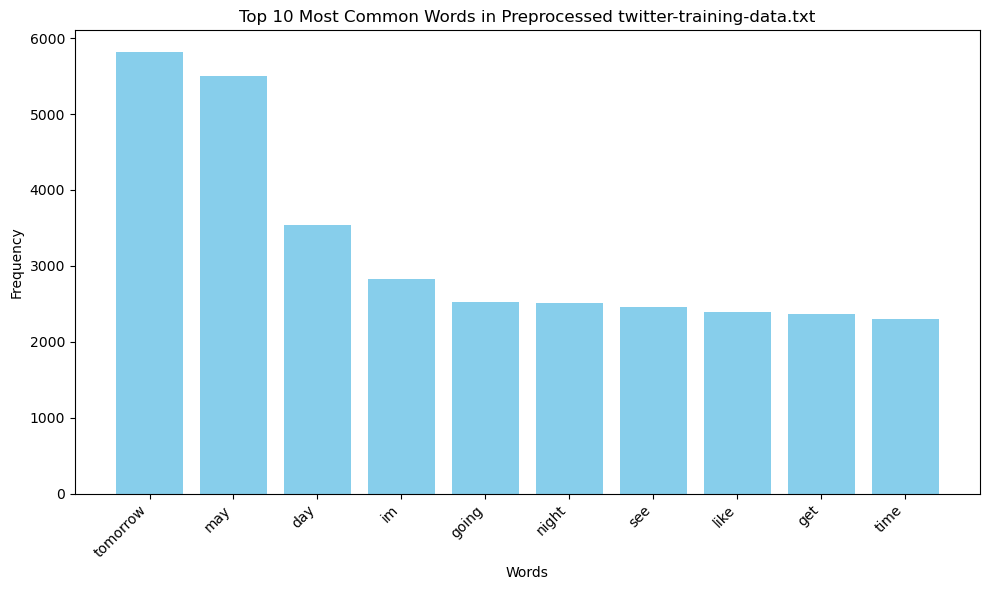


Preprocessed Development Texts:


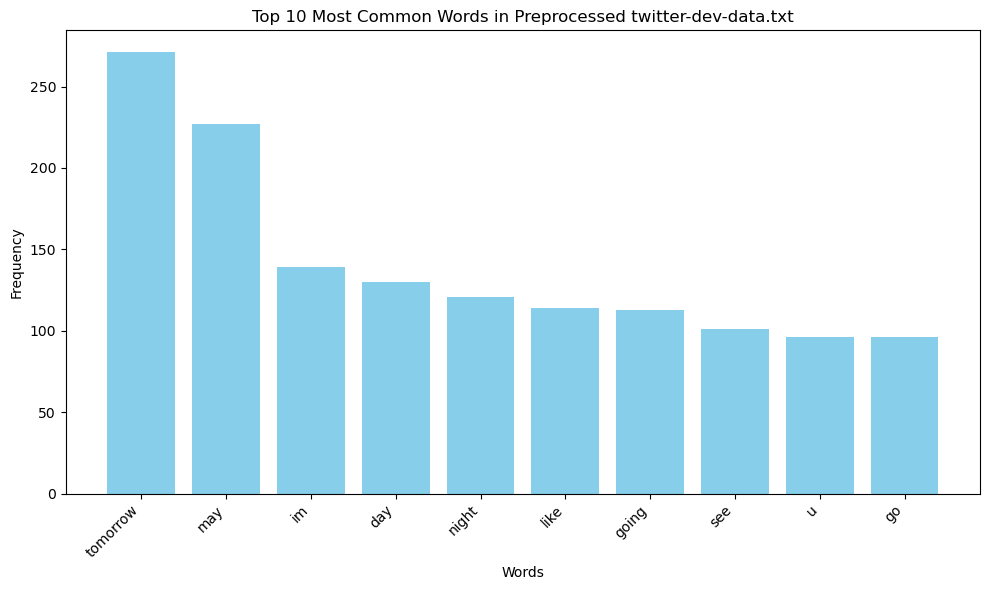


Preprocessed Test Texts:


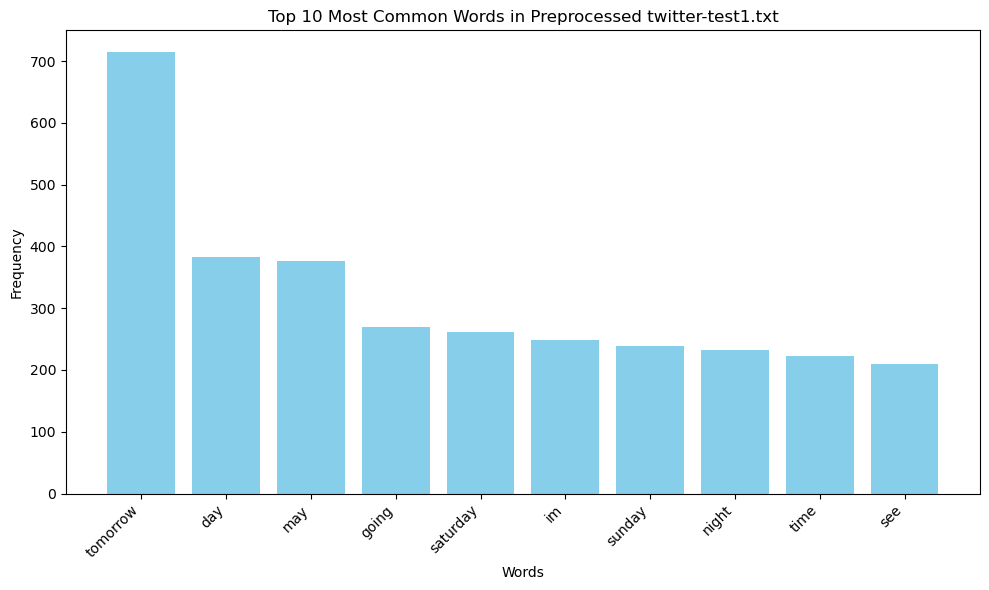

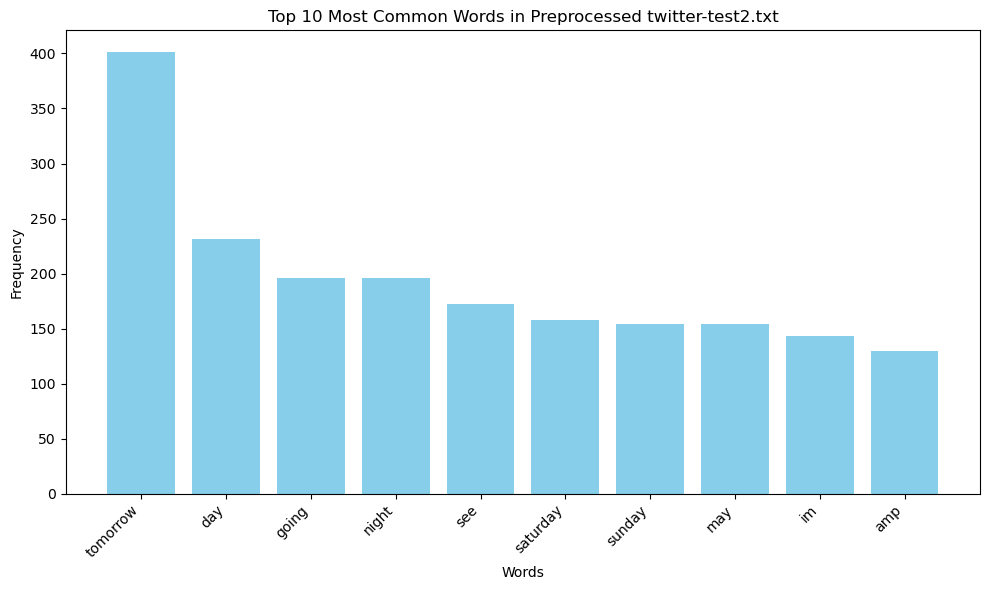

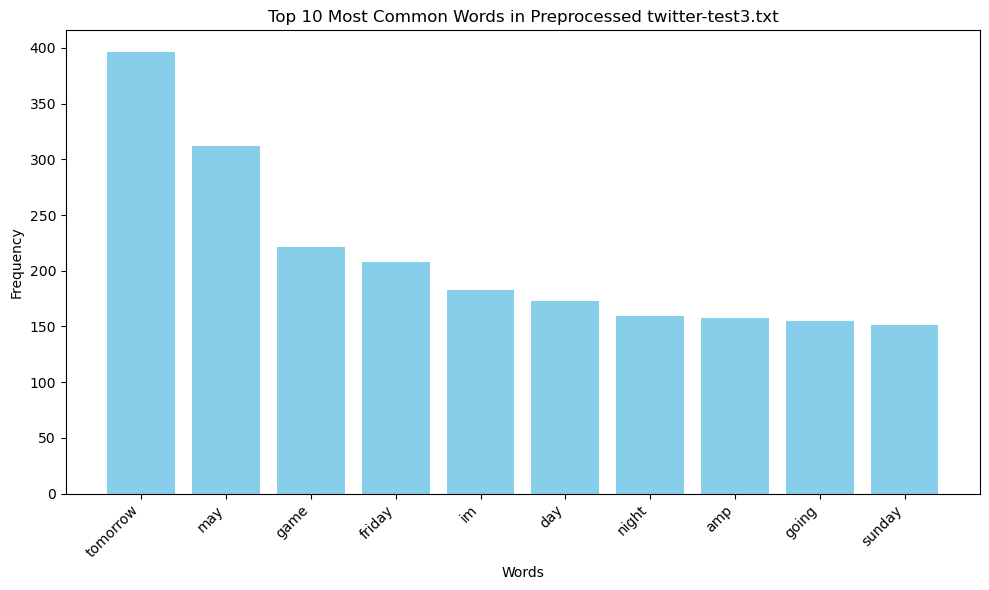

In [ ]:
# Function to tokenize preprocessed texts and count word occurrences
def count_words_in_preprocessed_texts(preprocessed_texts):
    all_words = []
    for text in preprocessed_texts:
        all_words.extend(word_tokenize(text))  # Tokenize preprocessed text into words
    word_counts = Counter(all_words)
    return word_counts

# Function to plot word frequency for preprocessed texts
def plot_word_frequency_for_preprocessed_texts(word_counts, dataset_name, num_words=10):
    top_words = word_counts.most_common(num_words)
    words, counts = zip(*top_words)

    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {num_words} Most Common Words in Preprocessed {dataset_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot word frequency for preprocessed training texts
print("Preprocessed Training Texts:")
for dataset, texts in preprocessed_training_texts.items():
    word_counts = count_words_in_preprocessed_texts(texts)
    plot_word_frequency_for_preprocessed_texts(word_counts, dataset)

# Plot word frequency for preprocessed development texts
print("\nPreprocessed Development Texts:")
for dataset, texts in preprocessed_dev_texts.items():
    word_counts = count_words_in_preprocessed_texts(texts)
    plot_word_frequency_for_preprocessed_texts(word_counts, dataset)

# Plot word frequency for preprocessed test texts
print("\nPreprocessed Test Texts:")
for dataset, texts in preprocessed_test_texts.items():
    word_counts = count_words_in_preprocessed_texts(texts)
    plot_word_frequency_for_preprocessed_texts(word_counts, dataset)
